## Support Vector Machines - Scratch Implementation

SVMs, as covered in the intro notebook, find a hyperplane that maximizes the margin between 2 sets.

Even with more than 2 labels/groups, the most common SVM processes compare 2 sets at a time to determine a hyperplane, with either taking 2 at a time or a one vs the rest approach.

### The Problem

Mathematically, we can come up with an objective that we are trying to optimize. In this case, we have a margin *m* to maximize. 


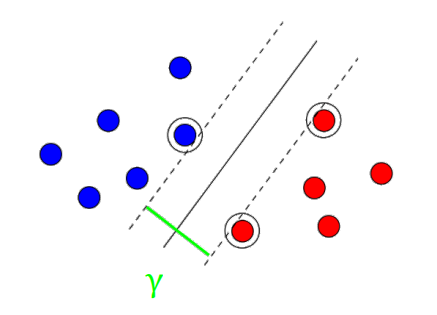

In [0]:
from IPython.display import Image
Image(filename="/content/data/margin.PNG") 

Here we'll go through code for the hard margin formulation, which doesn't allow for points to fall within the margin of the hyperplane.

Based on this definition, while we're maximizing m, our constraint is that the points must fall outside of the hyperplane and margin. Say *w* is vector normal to the hyperplane, then we can define the distance as follows:

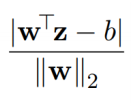

In [0]:
Image(filename="/content/data/distance.PNG") 

Here, the plane H is defined as all x such that w^T * x - b = 0. The distance uses z as a point not in H, the hyperplane. 

The constraint is that for all point in the given data sets, distance from the hyperplane must be greater than m.

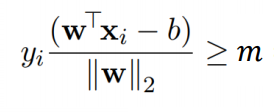

In [0]:
Image(filename="/content/data/constraint.PNG") 

The y_i is multiplied to make the numerator positive. This is also the reason our labels for this problem should be +1 or -1 for the 2 different groups.

Finally with some mathematical manipulation, we can take norm(w) = 1/m, and come up with the following final formulation for this problem.


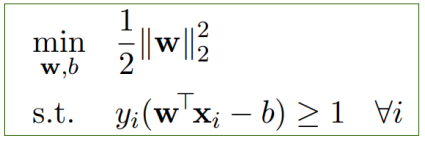

In [0]:
Image(filename="/content/data/problem.PNG") 

### Solving Optimization Problems

The problem above is a quadratic problem, and this problem is convex. What this means is that we're able to solve the problem with various techniques. We can also use cvxpy, a package specifically for solving convex optimization problems.

First, let's generate some data and visualize it:

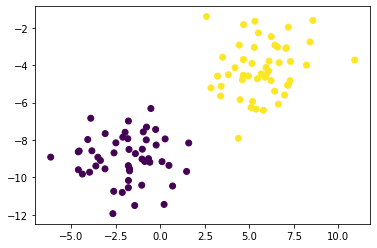

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples = 100, n_features = 2, centers = 2, cluster_std = 1.5, random_state = 40)

def plot_raw_data(X,y):
    plt.scatter(X[:,0], X[:,1], marker = 'o', c = y)
    plt.show()

plot_raw_data(X,y)

In [0]:
# Need to turn y to +1 and -1, currently +1 and 0
y[y == 0] = -1
print(y)

[ 1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1  1 -1  1  1
 -1  1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1 -1
 -1  1  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1 -1 -1 -1  1  1 -1  1 -1 -1
 -1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1 -1  1
 -1 -1 -1 -1]


In [0]:
import cvxpy as cp

w = cp.Variable(2)
b = cp.Variable(1)

Next we create our objective and the constraints with the 'variables' above.

Note: The cp.Variables refer to the actual variables we're optimizing in the problem.

In [0]:
ob = cp.Minimize(1/2*(w[0]**2+w[1]**2))
co = []
for i in range(len(X)):
    co.append(y[i]*(w[0]*X[i][0] + w[1]*X[i][1] - b) >= 1)

In [0]:
prob = cp.Problem(ob, co)
prob.solve()
# Returns the value of the objective after solving for the minimum

0.3078836992495939

In [0]:
print("Optimal w: " + str(w.value))
print("Optimal b: " + str(b.value))

Optimal w: [0.68148252 0.38903596]
Optimal b: [-1.08908035]


We can plot our solution and the margin using the original formula:

w^T * x - b = 0

And we know the margins are where the above term is equal to +1 and -1.

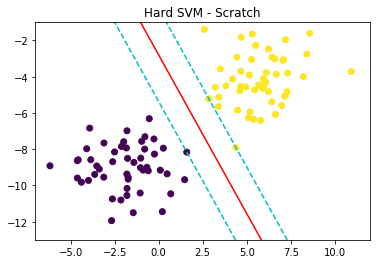

In [82]:
# Plot the solution with the original data
x = np.linspace(-7.5, 12, 1000)
plt.plot(x, (b.value[0] - w.value[0]*x)/w.value[1], "-r")

# Dashed refers to the decision boundary + margin
plt.plot(x, (1 + b.value[0] - w.value[0]*x)/w.value[1], "--c")
plt.plot(x, (-1 + b.value[0] - w.value[0]*x)/w.value[1], "--c")

plt.ylim(-13,-1)
plt.xlim(-7,12)
plt.title("Hard SVM - Scratch")
plot_raw_data(X,y)

### Short Note on Soft SVM

For Soft SVM, the issue lies in data that isn't neatly linearly separable.

For this, we must relax the constraint that every data point must be outside of the the decision boundary +- margin. Instead we allow some points to fall within/across this by introducing an error as a slack variable.

We also want to minimize this error to have few points fall across the decision boundary, and so we incorporate it into the decision boundary.

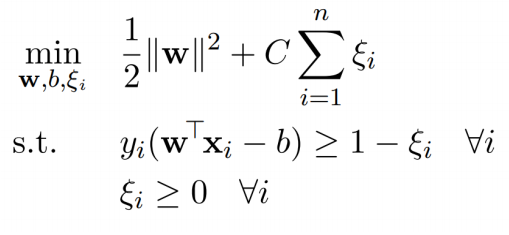

In [0]:
Image(filename="/content/data/soft.PNG") 

### Comparison to Scikit-Learn Implementation

The scikit-learn SVM implementation uses the above soft SVM formulation. As we see above when the data is linearly separable, we can easily set our error to be 0, simplifying to the hard SVM problem.

Let's compare our solution to scikit's out-of-the-box SVM solver:

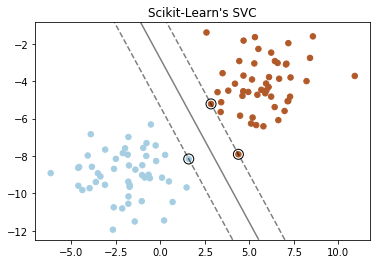

In [81]:
from sklearn import svm

svc = svm.SVC(kernel = "linear").fit(X, y)

def plot_boundary(clf, X, y, clf_name):

    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
    plt.title(clf_name)
    plt.show()

plot_boundary(svc, X, y, "Scikit-Learn's SVC")

Credit for proofs: EECS 189 Course Notes